In [ ]:
import keras
import cv2
import numpy as np
import argparse
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
tf.config.list_physical_devices('GPU') 
from tensorflow.keras.applications import VGG16,InceptionV3
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.layers import AveragePooling2D, Dropout,Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix
import seaborn as sn
import itertools
from sklearn.metrics import precision_recall_fscore_support
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, UpSampling2D, Add, Activation, Multiply, concatenate

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [ ]:
pip install kaggle

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d khoongweihao/covid19-xray-dataset-train-test-sets

 87% 73.0M/84.3M [00:02<00:00, 17.9MB/s]
100% 84.3M/84.3M [00:02<00:00, 29.7MB/s]


In [ ]:
import zipfile
zf = "/content/covid19-xray-dataset-train-test-sets.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

# Load the image data and train a model

In [ ]:
train_path = '/content/dataset/cnn/pneumonia_revamped/xray_dataset_covid19/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/xray_dataset_covid19/test'
val_path ='/content/dataset/cnn/pneumonia_revamped/xray_dataset_covid19/test'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
 validation_split = 0,
)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(train_path,
    target_size = (320, 320),
    shuffle=True,seed=42,class_mode="categorical",
    color_mode = 'rgb',
    batch_size = 16)
test_generator = test_datagen.flow_from_directory(test_path,
    target_size = (320, 320),
    color_mode = 'rgb',
    batch_size = 1,seed=42,class_mode="categorical",
    shuffle = False)
val_generator = test_datagen.flow_from_directory(val_path,
    target_size = (320, 320),
    color_mode = 'rgb',
    batch_size = 1,seed=42,class_mode="categorical",
    shuffle = False)

Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
train_data_dist=np.unique(train_generator.classes, return_counts=True)[1]
class_mapping_train = train_generator.class_indices
for key, val in class_mapping_train.items():
    print(f'The number of {key} images are {train_data_dist[val]} in training-set')
print('_____________________________________________________________________')
test_data_dist=np.unique(test_generator.classes, return_counts=True)[1]
class_mapping_test = test_generator.class_indices
for key, val in class_mapping_test.items():
    print(f'The number of {key} images are {test_data_dist[val]} in test-set')
print('_____________________________________________________________________')
val_data_dist=np.unique(val_generator.classes, return_counts=True)[1]
class_mapping_val = val_generator.class_indices
for key, val in class_mapping_val.items():
    print(f'The number of {key} images are {val_data_dist[val]} in validation-set')

The number of NORMAL images are 74 in training-set
The number of PNEUMONIA images are 74 in training-set
_____________________________________________________________________
The number of NORMAL images are 20 in test-set
The number of PNEUMONIA images are 20 in test-set
_____________________________________________________________________
The number of NORMAL images are 20 in validation-set
The number of PNEUMONIA images are 20 in validation-set


In [ ]:
basemodel = InceptionV3(weights='imagenet', include_top=False,input_tensor=Input(shape=(320, 320, 3)))
# basemodel = VGG16(input_tensor=Input(shape=(320, 320, 3)),include_top=False, weights="imagenet")

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
headModel = basemodel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)#pool_size=(4, 4)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [ ]:
model = Model(inputs=basemodel.input, outputs=headModel)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 159, 159, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 159, 159, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 159, 159, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
epochs= 100
lr = 1e-4
BS = 16

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=1e-4,decay=lr/epochs),metrics=["accuracy"])

In [ ]:
filepath="best_covid19_imporoved2.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

## Setting class weights to address the imbalance in data

In [ ]:
class_weight = {
    0:0.85,
    1:0.15
}

In [ ]:
model.fit_generator(train_generator,
                    steps_per_epoch = 320//BS,
                    epochs = epochs,
                    validation_data = val_generator,
                    validation_steps = 26,
                   callbacks=callbacks_list,
                   class_weight=class_weight,
                   )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
20/20 [==============================] - 161s 8s/step - loss: 0.2545 - accuracy: 0.4940 - val_loss: 0.2740 - val_accuracy: 0.8462

Epoch 00001: val_accuracy improved from -inf to 0.84615, saving model to best_covid19_imporoved2.h5


# Evaluating trained model on test-set

In [ ]:
filepath = '/content/best_covid19_imporoved2.h5'
new_model = load_model(filepath)

In [ ]:
prediction=new_model.predict(test_generator, use_multiprocessing=True)
print(prediction)

[[0.94314873 0.05685127]
 [0.9096211  0.09037887]
 [0.97319317 0.02680683]
 [0.9185748  0.08142523]
 [0.8844543  0.11554564]
 [0.79481953 0.2051805 ]
 [0.8926748  0.10732518]
 [0.9458394  0.05416064]
 [0.9745531  0.02544693]
 [0.9189488  0.0810511 ]
 [0.96711904 0.03288097]
 [0.93310267 0.06689734]
 [0.8831154  0.11688465]
 [0.9632713  0.03672867]
 [0.95969725 0.04030274]
 [0.9645221  0.03547788]
 [0.95902574 0.04097423]
 [0.9389498  0.06105011]
 [0.95404375 0.04595621]
 [0.97871494 0.02128508]
 [0.38509992 0.61490005]
 [0.5533084  0.44669157]
 [0.31852335 0.68147665]
 [0.7510357  0.24896432]
 [0.8277947  0.17220533]
 [0.58760214 0.41239783]
 [0.12593861 0.87406135]
 [0.3410104  0.6589896 ]
 [0.42989895 0.5701011 ]
 [0.22570123 0.7742988 ]
 [0.23669317 0.76330686]
 [0.61809015 0.38190988]
 [0.5279893  0.47201064]
 [0.20761134 0.7923886 ]
 [0.15370585 0.84629416]
 [0.55274737 0.44725263]
 [0.10586765 0.8941324 ]
 [0.5105639  0.48943615]
 [0.32531998 0.67468005]
 [0.29527152 0.7047284 ]]

## Make Confusion Matrix

Confusion matrix, without normalization


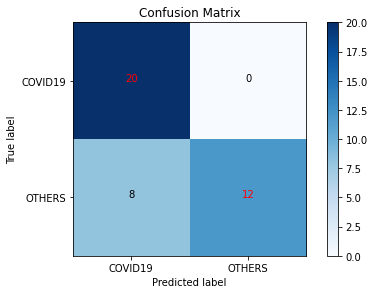

Normalized confusion matrix


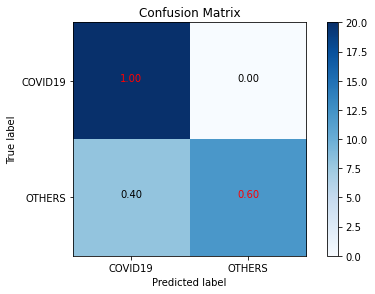

In [ ]:
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
y_pred = np.argmax(prediction, axis=1)
cm=confusion_matrix(test_generator.classes, y_pred)
cm_labels= ['COVID19','OTHERS']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix')
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix', normalize=True)

## Show the prediction of model on some images of test-set

prob:[0.94314873 0.05685127]
NORMAL/NORMAL2-IM-0035-0001.jpeg


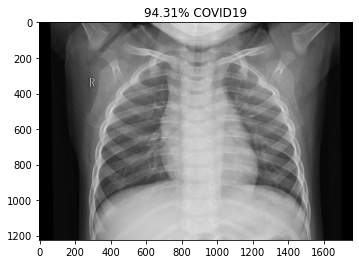

prob:[0.9096211  0.09037887]
NORMAL/NORMAL2-IM-0052-0001.jpeg


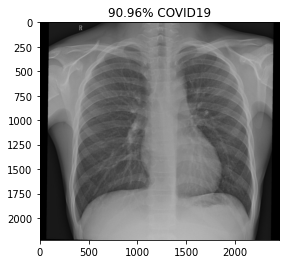

prob:[0.97319317 0.02680683]
NORMAL/NORMAL2-IM-0058-0001.jpeg


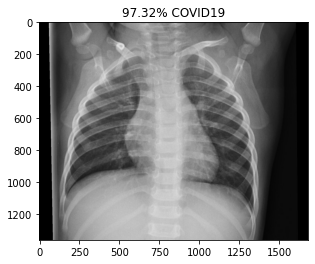

prob:[0.9185748  0.08142523]
NORMAL/NORMAL2-IM-0059-0001.jpeg


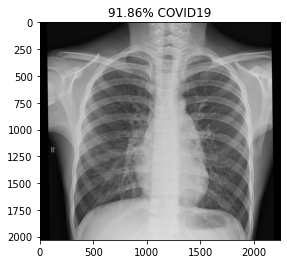

prob:[0.8844543  0.11554564]
NORMAL/NORMAL2-IM-0072-0001.jpeg


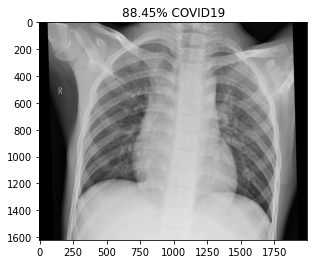

prob:[0.79481953 0.2051805 ]
NORMAL/NORMAL2-IM-0073-0001.jpeg


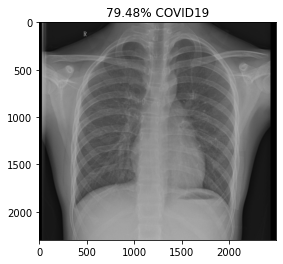

prob:[0.8926748  0.10732518]
NORMAL/NORMAL2-IM-0092-0001.jpeg


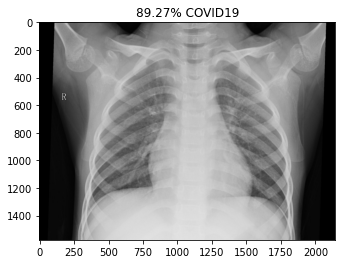

prob:[0.9458394  0.05416064]
NORMAL/NORMAL2-IM-0105-0001.jpeg


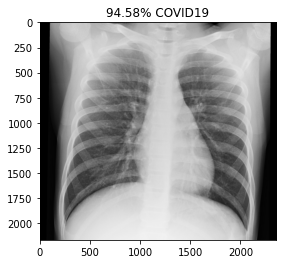

prob:[0.9745531  0.02544693]
NORMAL/NORMAL2-IM-0110-0001.jpeg


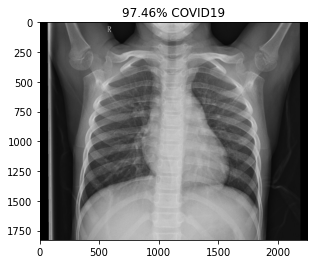

prob:[0.9189488 0.0810511]
NORMAL/NORMAL2-IM-0111-0001.jpeg


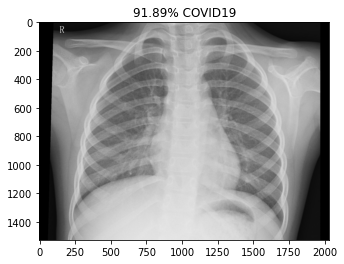

prob:[0.96711904 0.03288097]
NORMAL/NORMAL2-IM-0112-0001.jpeg


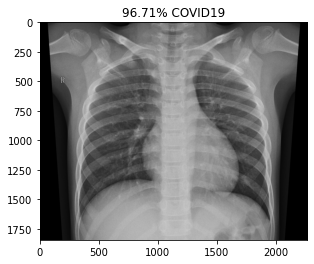

prob:[0.93310267 0.06689734]
NORMAL/NORMAL2-IM-0117-0001.jpeg


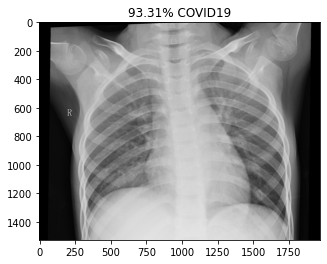

prob:[0.8831154  0.11688465]
NORMAL/NORMAL2-IM-0120-0001.jpeg


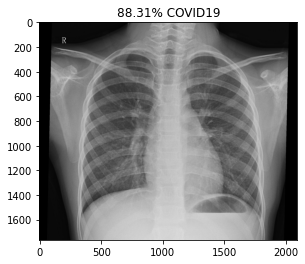

prob:[0.9632713  0.03672867]
NORMAL/NORMAL2-IM-0123-0001.jpeg


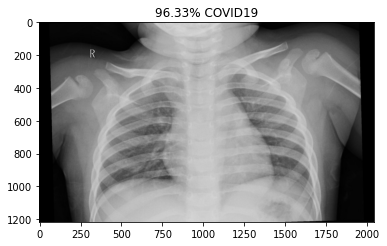

prob:[0.95969725 0.04030274]
NORMAL/NORMAL2-IM-0130-0001.jpeg


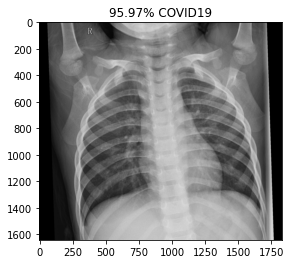

prob:[0.9645221  0.03547788]
NORMAL/NORMAL2-IM-0131-0001.jpeg


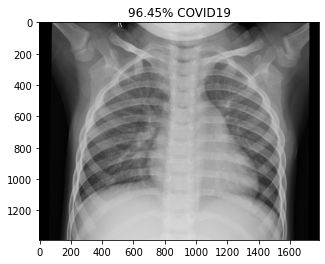

prob:[0.95902574 0.04097423]
NORMAL/NORMAL2-IM-0132-0001.jpeg


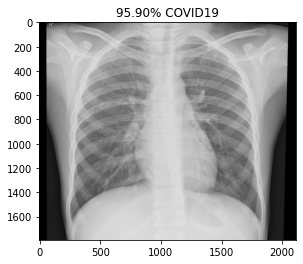

prob:[0.9389498  0.06105011]
NORMAL/NORMAL2-IM-0139-0001.jpeg


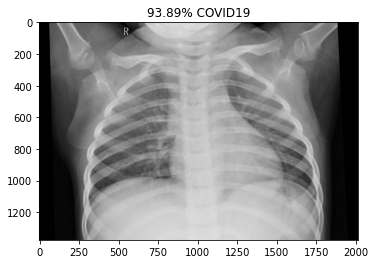

prob:[0.95404375 0.04595621]
NORMAL/NORMAL2-IM-0145-0001.jpeg


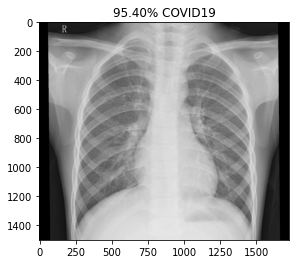

prob:[0.97871494 0.02128508]
NORMAL/NORMAL2-IM-0171-0001.jpeg


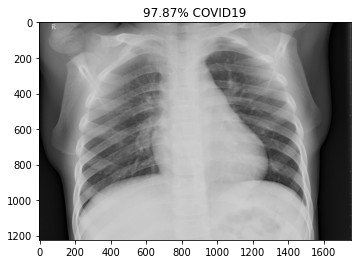

prob:[0.38509992 0.61490005]
PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0.jpeg


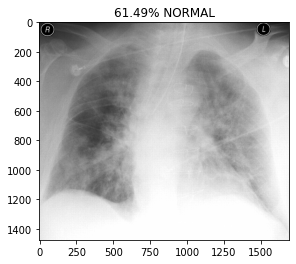

prob:[0.5533084  0.44669157]
PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg


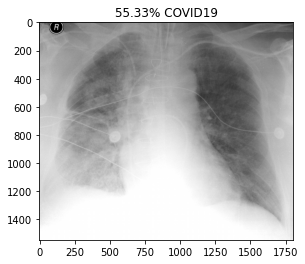

prob:[0.31852335 0.68147665]
PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10.jpeg


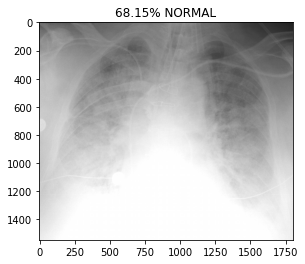

prob:[0.7510357  0.24896432]
PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day7.jpeg


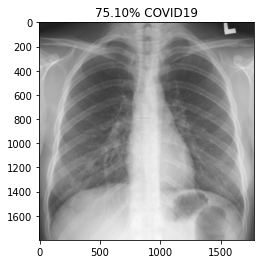

prob:[0.8277947  0.17220533]
PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day12.jpeg


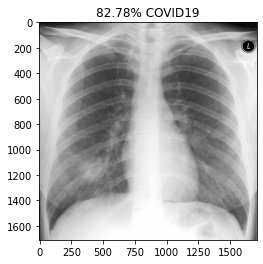

prob:[0.58760214 0.41239783]
PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g05x-Fig5-day9.jpeg


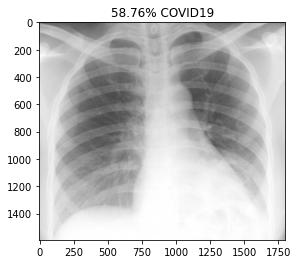

prob:[0.12593861 0.87406135]
PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g07a-Fig7a-day5.jpeg


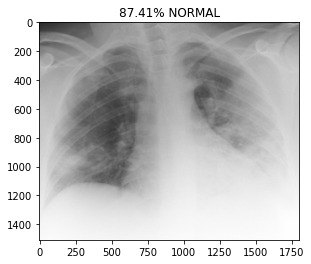

prob:[0.3410104 0.6589896]
PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g07b-Fig7b-day12.jpeg


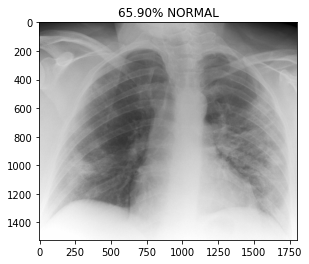

prob:[0.42989895 0.5701011 ]
PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g09a-Fig9a-day17.jpeg


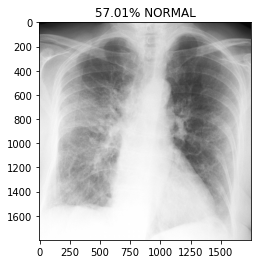

prob:[0.22570123 0.7742988 ]
PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g09b-Fig9b-day19.jpeg


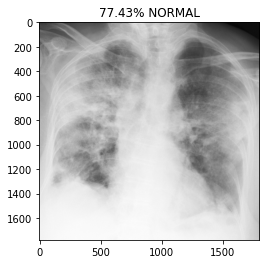

In [ ]:
import cv2
import matplotlib.image as mpimg
prediction = prediction[:30]
for index, probability in enumerate(prediction):
    image_path = test_path + "/" +test_generator.filenames[index]
    image = mpimg.imread(image_path)
     #BGR TO RGB conversion using CV2
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixels = np.array(image)
    plt.imshow(pixels)
    print("prob:{}".format(probability))
    print(test_generator.filenames[index])
    if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% NORMAL')
    else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% COVID19')
    plt.show()

## Plotting ROC curve and generating classification report

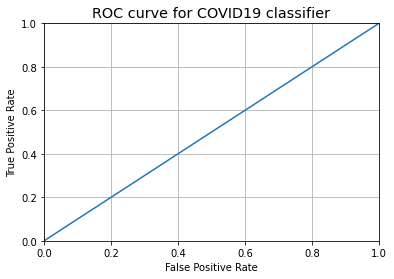

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_generator.classes, y_pred)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for COVID19 classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [ ]:
print('Classification Report')
target_names = ['COVID19 Pneumonia ','OTHERS']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
                    precision    recall  f1-score   support

COVID19 Pneumonia        0.50      1.00      0.67        20
            OTHERS       0.00      0.00      0.00        20

          accuracy                           0.50        40
         macro avg       0.25      0.50      0.33        40
      weighted avg       0.25      0.50      0.33        40



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
